In [51]:
import pandas as pd
import numpy as np
from scipy import stats

file = '/Users/quintonaguilera/Desktop/BoE/(PRA)_(OFFG)_8350731_v_1_010242 - Analyst Data Science - Technical Assessment - Data.XLSX'

# Read all sheets into a dictionary
df1_raw = pd.read_excel(file, sheet_name='Dataset 1 - General')
df2_raw = pd.read_excel(file, sheet_name='Dataset 2 - Underwriting')

df1_raw.rename(columns={'Unnamed: 0': 'firm'}, inplace=True)
df2_raw.rename(columns={'Unnamed: 0': 'firm'}, inplace=True)
df2_raw = df2_raw[:len(df1_raw)]

In [67]:
def identify_9sd_outlier_records(df):
    '''
    Function to highlight which records have fields that are 9SD different from peers. 
    
    Parameters:
        - Dataframe to check
        
    Returns:
        - dataframe with removed 9SD records and a summary of issue records.
    
    '''
    
    df = df[1:].copy() # To avoid setting with copy
    means = df.mean()
    std = df.std()
    
    for col in df.columns[1:]:
        col_mean = means[col]
        col_std = std[col]
        threshold = col_mean + 9 * col_std
        df.loc[df[col] > threshold, col] = '9SD WIDE'
        
    issue_firms = df[df.isin(['9SD WIDE']).any(axis=1)]
    non_issue_firms = df[~df.isin(['9SD WIDE']).any(axis=1)]
    subset = issue_firms.columns[1:]
    no_9sd = (issue_firms[subset] == '9SD WIDE').sum(axis=1)
    print(no_9sd)
    
    return non_issue_firms
    

df1 = identify_9sd_outlier_records(df1_raw)


4      13
10      1
26      1
66      1
105     8
127     2
131     1
210     9
216     1
247     1
311     5
320     1
dtype: int64


In [68]:
df2 = identify_9sd_outlier_records(df2_raw)

17     1
28     6
70     1
99     3
105    3
112    2
161    2
166    3
188    6
216    6
228    2
270    1
284    3
dtype: int64


In [54]:
# Eye-test, df is no zero index

# Record 1 in the SCR category:
df1 = df1.drop(1)


In [62]:
# Section 1 Table Creation

gwp_cols = df1.filter(like='GWP (£m)')
nwp_cols = df1.filter(like='NWP (£m)')
scr_cols = df1.filter(like='SCR coverage ratio')

gci_cols = df2.filter(like='Gross claims incurred (£m)')
ncr_cols = df2.filter(like='Net combined ratio')

years = [2016, 2017, 2018, 2019, 2020]
final_col_names = ['GWP', 'NWP', 'SCR', 'GCI', 'NCR']

sec1_df = pd.DataFrame(columns = final_col_names, index=years)
    

def add_to_sec1_df(sec1_df, col_name, cols, df):
    '''
    Function that will add the average of specific columns to the main df used for section 1.
    
    Parameters:
        Sec1_df - The main df

        col_name - What the new column will be called

        cols - The list of columns to average in the old df

        df - Does it come from df1 or df2
    
    Returns:
        Sec1_df with the columns appended
    '''
    
    temp_df = pd.concat([df['firm'], cols], axis=1).dropna()
    temp_sum = temp_df.mean(axis=0).reset_index()
    temp_sum.columns = ['YE', col_name]
    temp_sum.index = years
    sec1_df[col_name] = temp_sum[col_name]
    return sec1_df

    

sec1_df = add_to_sec1_df(sec1_df, 'GWP', gwp_cols, df1)
sec1_df = add_to_sec1_df(sec1_df, 'NWP', nwp_cols, df1)
sec1_df = add_to_sec1_df(sec1_df, 'SCR', scr_cols, df1)
sec1_df = add_to_sec1_df(sec1_df, 'GCI', gci_cols, df2)
sec1_df = add_to_sec1_df(sec1_df, 'NCR', ncr_cols, df2)
sec1_df.to_csv('sec1tab.csv')



In [82]:
# Section 2.1 Table Creation
scr_df = pd.concat([df1['firm'], scr_cols], axis=1).dropna()
subset = scr_df[scr_cols.columns]
no_breaches = (subset < 1).sum(axis=1)
scr_df['no_breaches'] = no_breaches
print(scr_df['no_breaches'].value_counts())


# Section 2.2 Table Creation
average_scr = scr_cols[1:]
average_scr = average_scr.mean(axis=1)

average_gwp = gwp_cols[1:]
average_gwp = average_gwp.mean(axis=1)

gwp_scr_df = pd.concat([df1['firm'],average_scr, average_gwp], axis=1).dropna()
gwp_scr_df.columns = ['firm', 'SCR', 'GWP']
gwp_scr_df = gwp_scr_df.sort_values(by='GWP', ascending=False)

no_firms = len(gwp_scr_df)
bot_thrd_ub = round(no_firms * (1/3))
mid_thrd_ub = bot_thrd_ub * 2

frm_bot_thrd = gwp_scr_df[:bot_thrd_ub]
frm_mid_thrd = gwp_scr_df[bot_thrd_ub:mid_thrd_ub]
frm_top_thrd = gwp_scr_df[mid_thrd_ub:]

print(frm_bot_thrd['SCR'].mean())
print(frm_mid_thrd['SCR'].mean())
print(frm_top_thrd['SCR'].mean())

1    92
2    64
0    56
3    44
4    28
5    28
Name: no_breaches, dtype: int64
1.9158995859155228
2.2623321410126898
5.414700593817333


In [78]:
stats.ttest_ind(frm_bot_thrd['SCR'],frm_mid_thrd['SCR'])

Ttest_indResult(statistic=-1.5349182695039243, pvalue=0.12633832437644218)

In [79]:
stats.ttest_ind(frm_bot_thrd['SCR'],frm_top_thrd['SCR'])

Ttest_indResult(statistic=-3.2876622675140568, pvalue=0.0011886772596395425)

In [80]:
stats.ttest_ind(frm_mid_thrd['SCR'],frm_top_thrd['SCR'])

Ttest_indResult(statistic=-2.9642504129274427, pvalue=0.0033935357524126873)

In [85]:
# Section 3

xsa_cols = df1.filter(like='Excess of assets over liabilities (£m) [= equity]')
pnc_cols = df2.filter(like='Pure net claims ratio')


def reformat_to_pct_ch(cols):
    '''
    Function that gets the values for a specific column per firm, per year and changes them 
    into pct change for more straightforward interfirm comparison.
    
    Parameters:
        - Cols: a df containing only relevant columns
        
    Returns:
        - Pct change per firm per year in said column
    
    '''
    temp = cols[1:]
    temp.columns = years
    temp = temp.T
    temp = temp.pct_change()
    temp = temp.fillna(0)
    temp = temp.replace([np.inf, -np.inf], 0)
    return temp
    

# dfs used for analysis in section 3
gci_cols3 = reformat_to_pct_ch(gci_cols)
xsa_cols3 = reformat_to_pct_ch(xsa_cols)
pnc_cols3 = reformat_to_pct_ch(pnc_cols)
gci_cols3

,2,3,4,5,6,7,8,9,10,11,...,316,317,318,319,320,321,322,323,324,325
2016,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
2017,-0.336833,0.0,3.955216,7.735352,2.656312,0.0,-1.258595,-0.589721,26.481688,-0.780227,...,2.640637,7.491829,1.858412,10.599285,0.0,0.711585,1.338013,0.0,1.917082,0.100339
2018,0.156356,0.0,0.237116,0.623914,-0.203733,0.0,5.398543,1.204098,0.371154,0.699650,...,-0.023293,2.571157,-2.656329,-0.798840,0.0,-0.295227,-0.428808,0.0,-0.444460,1.844746
2019,-1.000000,0.0,-0.519063,-0.748183,-0.293332,0.0,-1.000000,-0.591071,-0.111034,3.390868,...,-0.609141,0.245730,-0.461804,-0.889934,0.0,-0.258730,0.015006,0.0,0.333025,-0.940366
2020,0.000000,0.0,-0.913234,-0.965953,0.043506,0.0,0.000000,-1.000000,0.542448,0.872408,...,1.714564,-0.908158,-0.566600,39.818074,0.0,-0.373971,-0.458929,0.0,-0.924992,-0.135932


In [87]:
pnc_cols3.to_csv('sec3_pnc.csv')

In [94]:
# Section 4

average_xsa = xsa_cols[1:].mean(axis=1)
average_pnc = pnc_cols[1:].mean(axis=1)
average_nwp = nwp_cols[1:].mean(axis=1)
average_ncr = ncr_cols[1:].mean(axis=1)
average_gci = gci_cols[1:].mean(axis=1)

kmc_pca_df = pd.concat([average_scr, 
                        average_gwp,
                        average_xsa,
                        average_pnc,
                        average_nwp,
                        average_ncr,
                        average_gci
                       ], axis=1).dropna()

prep_cols = ['SCR', 'GWP', 'XSA', 'PNC', 'NWP', 'NCR', 'GCI']
# kmc_pca_df.columns = kmc_pca_cols

# kmc_pca_df = kmc_pca_df[prep_cols]
kmc_pca_df

,0,1,2,3,4,5,6
3,1.133127,78.578846,346.847126,0.000000,35.760105,0.000000,0.000000
5,3.124074,48.345110,115.002349,0.969700,71.990032,1.222328,269.179206
6,1.299774,3780.159483,4990.762362,0.621079,3137.544845,0.677076,294.481119
7,1.207964,8616.174240,10232.547756,0.000000,6377.697934,0.000000,0.000000
8,0.000000,0.000000,0.000000,-0.127102,0.000000,0.195617,-0.019608
...,...,...,...,...,...,...,...
321,6.169212,15.810911,41.730253,0.496637,4.855652,0.596259,5.148679
322,1.692352,1641.277935,2768.633500,0.224810,2935.647964,1.382454,107.450121
323,19.556501,0.000000,69.855025,0.000000,0.000000,0.000000,0.000000
324,0.745409,101.384970,46.221204,0.441964,24.060966,0.988765,4.994887


1 1443961632.3039093
2 549630344.5014424
3 340720608.1637807
4 248406851.023729
5 176996351.86664745


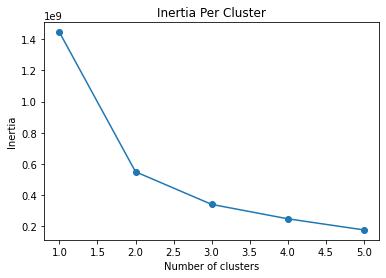

In [97]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


inertias = []

for i in range(1,6):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(kmc_pca_df)
    inertias.append(kmeans.inertia_)
    print(i, kmeans.inertia_)

plt.plot(range(1,6), inertias, marker='o')
plt.title('Inertia Per Cluster')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show() 